<a href="https://colab.research.google.com/github/kashif-kairo/YouTube-Trending-Videos-Analysis/blob/main/Youtube_Trending_Videos_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Youtube Trending Videos Analysis**

The dataset that I will be using for the analysis of Youtube trending videos was collected over 205 days. For each of those days, the dataset contains data on trending videos for that day. It contains data on over 40,000 trending videos.

We will analyze the data to get insight on trending YouTube videos, to see what is common among all trending videos. This information can also be used by people who want to increase the popularity of their videos on YouTube.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datasnaek/youtube-new")

print("Path to dataset files:", path)

100%|██████████| 201M/201M [00:02<00:00, 101MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/datasnaek/youtube-new/versions/115


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
from collections import Counter
import datetime
import wordcloud
import json

In [7]:
df = pd.read_csv("/content/USvideos.csv")
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

In [9]:
df["description"] = df["description"].fillna(value="")

In [33]:
df.describe()

,category_id,views,likes,dislikes,comment_count,title_length
count,40949.00,40949.00,40949.00,40949.00,40949.00,40949.00
mean,19.97,2360784.64,74266.70,3711.40,8446.80,48.58
std,7.57,7394113.76,228885.34,29029.71,37430.49,19.62
min,1.00,549.00,0.00,0.00,0.00,3.00
25%,17.00,242329.00,5424.00,202.00,614.00,34.00
50%,24.00,681861.00,18091.00,631.00,1856.00,46.00
75%,25.00,1823157.00,55417.00,1938.00,5755.00,61.00
max,43.00,225211923.00,5613827.00,1674420.00,1361580.00,100.00


# **Key Observation**

* The average number of views of a trending video is 2,360,784. The median value of the number of views is 681,861, which means that half of the trending videos have less than this number and the other half have views greater than this number.

* The average number of likes for a trending video is 74,266, while the average number of likes is 3,711.

* The average number of comments is 8,446 while the median is 1,856.

#**Data Visualization**

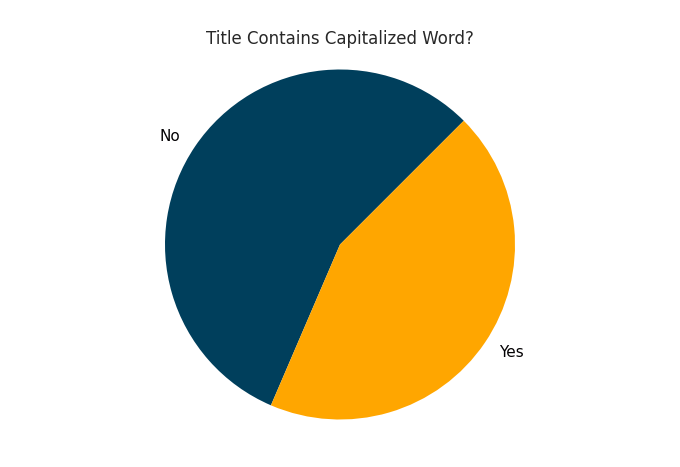

In [17]:
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False


df["contains_capitalized"] = df["title"].apply(contains_capitalized_word)

value_counts = df["contains_capitalized"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'],
           colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'}, startangle=45)
_ = ax.axis('equal')
_ = ax.set_title('Title Contains Capitalized Word?')

We can see that 44% of trending video titles contain at least one word in all caps. We will use our added variable later to analyze the correlation between the variables.

Let’s add another column to our dataset to analyze the length of titles of videos, then plot the title length histogram to get an idea of the length of trending video titles:

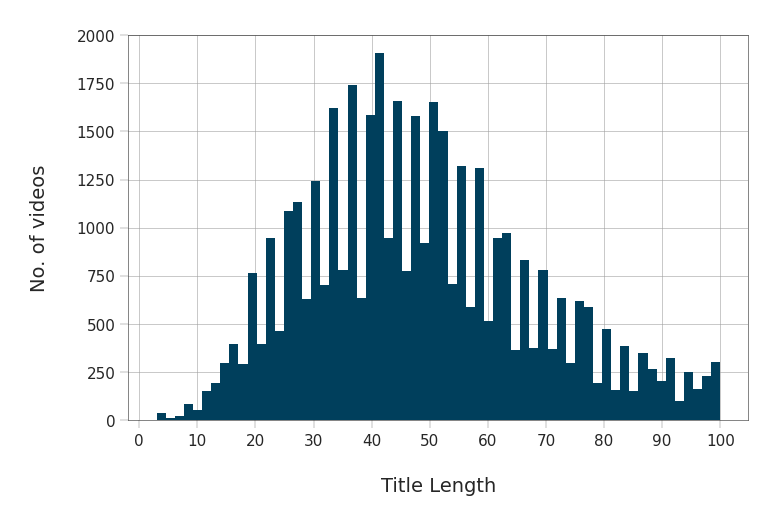

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Sans"

# Assuming df is your DataFrame and PLOT_COLORS is defined
df["title_length"] = df["title"].apply(lambda x: len(x))

fig, ax = plt.subplots()
sns.histplot(df["title_length"], kde=False, color=PLOT_COLORS[4], alpha=1, ax=ax)

# Dynamically set x-ticks based on the data
max_title_length = df["title_length"].max()
ax.set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, max_title_length + 10, 10))

plt.show()

We can see that the videos title length distribution looks like a normal distribution, where most videos have a title length of around 30-60 characters. Now, let’s draw a scatter plot to analyze the relationship between the title length and the number of views:

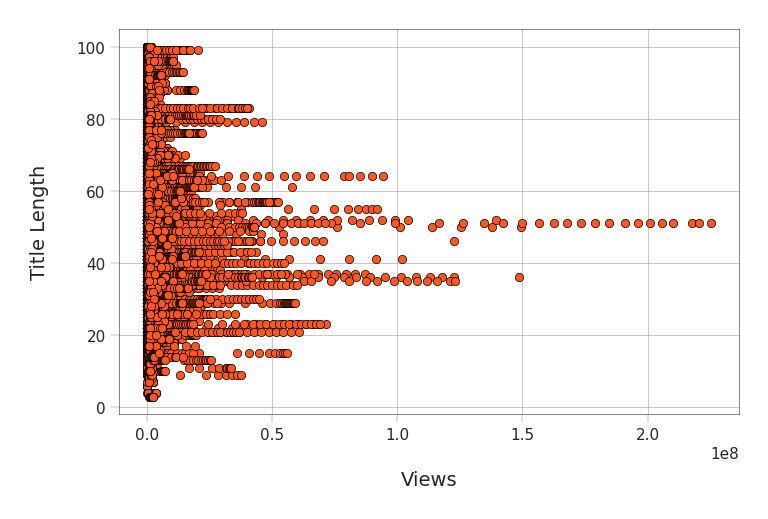

In [21]:
fig, ax = plt.subplots()
_ = ax.scatter(x=df['views'], y=df['title_length'], color=PLOT_COLORS[2], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Title Length")

Looking at the scatter plot, we can tell that there is no relationship between the length of the title and the number of views. However, we do notice an interesting thing that the Videos having 100,000,000 and more views have a title length of between 33 and 55 characters or so.

# **Correlation**

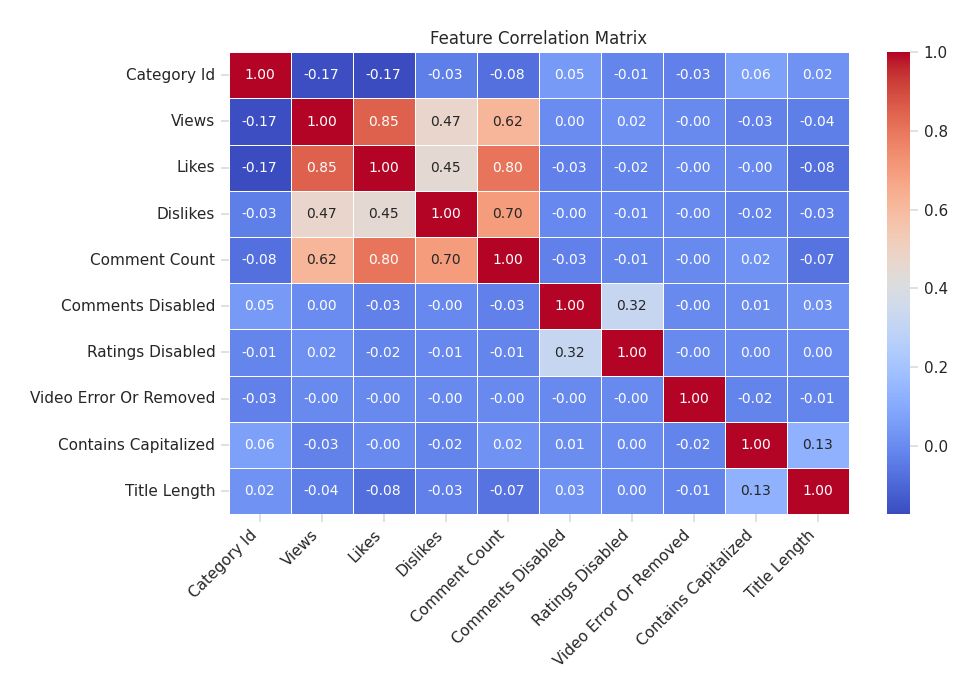

In [31]:

# Select only numeric and boolean columns
numeric_df = df.select_dtypes(include=['number', 'bool'])

# Generate formatted labels
h_labels = [x.replace('_', ' ').title() for x in numeric_df.columns]

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", xticklabels=h_labels,
            yticklabels=h_labels, cmap="coolwarm", linewidths=0.5, ax=ax)

# Improve layout
ax.set_title("Feature Correlation Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


The correlation map and correlation table above indicate that views and likes are strongly positively correlated.

Let’s see if some words are used meaningfully in trending video titles. Let’s draw a word cloud for the titles of our trending videos, which is a way to visualize the most common words in the titles; the more common the word, the larger its font-size:

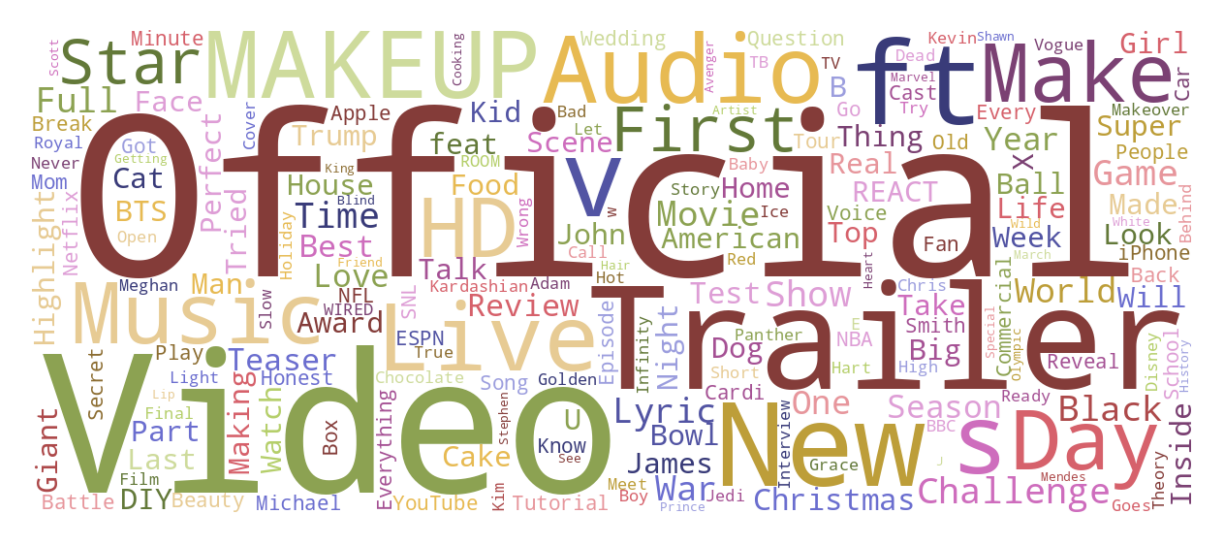

In [32]:
title_words = list(df["title"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
wc = wordcloud.WordCloud(width=1200, height=500,
                         collocations=False, background_color="white",
                         colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")